# Video Analysis of the Pendulum
We use the package "opencv" to analyze the position of the pendulum.  

Opencv is readily available, but I have found it a little tricky to get it installed with "ffmpeg" and "gstreamer"; I have ended up doing it from source.  

The general algorithm will be to go through the movie- use open cv to load each frame; do a "background subtraction", and then find the mean of the pendulum position as a function of time.  

Start by just opening the video.

In [1]:
import numpy as np
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('figure',dpi=250)

movie=cv2.VideoCapture('VID_20180917_132203.mp4')
length = int(movie.get(cv2.CAP_PROP_FRAME_COUNT ))
width  = int(movie.get(cv2.CAP_PROP_FRAME_WIDTH ))
height = int(movie.get(cv2.CAP_PROP_FRAME_HEIGHT ))
fps    = movie.get(cv2.CAP_PROP_FPS)
print ('length %d width %d height %d fps %d' % ( length,width,height,fps))
halfwidth=int(width/2)
halfheight=int(height/2)

length 0 width 0 height 0 fps 0


First, let's just step through and look at the first frames just to see how the code works

In [ ]:
#length=19000
for frameNumber in range(0,length):
    ret,frame=movie.read()
    fr2=cv2.resize(frame,(halfwidth,halfheight))
    cv2.imshow('picture',fr2)
#    cv2.resizeWindow('picture',int(width/4),int(height/4))
    key=cv2.waitKey(0)
    if key==ord('q'):
        break


That gets boring fast!  Let's skip through the frames, 5 seconds at a time

In [ ]:
for frameNumber in range(0,length,150):
    movie.set(cv2.CAP_PROP_POS_FRAMES,frameNumber)
    ret,frame=movie.read()
    cv2.imshow('picture',frame)
    key=cv2.waitKey(0)
    if key==ord('q'):
        break
print('Last Frame number was', frameNumber)

Last Frame number was 300


Starting at frame 900, lets look forward to where we should start the analysis

In [ ]:
font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (500,500)
fontScale              = 1
fontColor              = (255,255,255)
lineType               = 2

for frameNumber in range(900,length,15):
    movie.set(cv2.CAP_PROP_POS_FRAMES,frameNumber)
    ret,frame=movie.read()
    text=str('Frame Number %d' %frameNumber)
    cv2.putText(frame,text,
        bottomLeftCornerOfText, font, fontScale,fontColor,lineType)
    cv2.imshow('picture',frame)
    key=cv2.waitKey(0)
    if key==ord('q'):
        break
print('Last Frame number was', frameNumber)

Last Frame number was 930


We pick Frame 1250 as a reasonable place to start.

In [ ]:
firstFrame=1250
fgbg = cv2.createBackgroundSubtractorMOG2()
#Use first few frames to 'train' the background subtractor
for frameNumber in range(firstFrame,firstFrame+10):
    movie.set(cv2.CAP_PROP_POS_FRAMES,frameNumber)
    ret,frame=movie.read()
    fgmask=fgbg.apply(frame)

frameCount=0 #number of times FindBall is called
ny,nx=fgmask.shape  #note shape is rows, columns and counts from upper left in an image
xpixel=np.arange(0,nx)
ypixel=np.arange(0,ny)

def GetFGMeans(bounds):
    '''GetFGMeans calculates the Mean and standard deviation of the 2d foreground array fg.
    It assumes that there are global variables xpixel and ypixel that contain pixel numbers
    bounds is an list that is xmin, xmax, ymin, ymax'''
    xmin,ymin, xmax,ymax=bounds
    projX=np.sum(fg[ymin:ymax,xmin:xmax],axis=0) #axis =0 means sum over "rows" --ie over y values
    projY=np.sum(fg[ymin:ymax,xmin:xmax],axis=1)
    meanx=np.sum(projX*xpixel[xmin:xmax])/(1+np.sum(projX))
    #add 1 to RMS to ensure that we are never smaller than a pixel
    RMSx=1+np.sqrt(np.sum(projX*(xpixel[xmin:xmax]-meanx)**2)/(1+np.sum(projX)))
    meany=np.sum(projY*ypixel[ymin:ymax])/(1+np.sum(projY))
    RMSy=1+np.sqrt(np.sum(projY*(ypixel[ymin:ymax]-meany)**2)/(1+np.sum(projY)))
    if meanx==0:
        print (xmin,xmax,ymin,ymax,np.sum(projX),np.sum(projY),fg[ymin:ymax,xmin:xmax])
    return ([meanx,meany,RMSx,RMSy])


def FindBall(frameNumber, draw=False):
    '''This function locates the ball in a frame and returns it central position in pixels.
    if draw is true it surrounds the ball with a rectangle and displays it'''
    global frameCount
    global movie
    global fgmask
    global fgbg
    global fg
    global oldxmean
    global oldymean
    movie.set(cv2.CAP_PROP_POS_FRAMES,frameNumber)
    ret,frame=movie.read()
    if not ret:
        return -99999

    print('framecount=',frameCount)
    fgmask=fgbg.apply(frame)

    fg=np.where(fgmask!=0,1,0)
    #starting around the previous answer can speed the algorithm up quite a bit, and also makes us robust against
    # things that happen at the edges of the picture.  But if we get a wrong answer (the mean ends up going to zero)
    # we can end up stuck there.
    if frameCount>0 and oldxmean != 0:         #oldxmean goes to zero in some failures; this allows possible recovery
        bounds=(int(oldxmean-150), int(oldymean-150), int(oldxmean+150),int(oldymean+150))
    else:
        bounds=(0,200,width,800)

    if draw:
        plt.figure()
        plt.title('Single frame, straight from camera')
        plt.imshow(frame)
        plt.figure()
        plt.title('Foreground mask: the part of the picture that is moving')
        plt.imshow(fg)

    oldxmean=0
    oldymean=0
    loop=True
    count=0  # the count variable is used to make sure that the loop doesn't go forever
    #  That can happen when someone walks through the picture
    while loop:
        cv2.rectangle(fgmask,(bounds[0],bounds[1]),(bounds[2],bounds[3]),(255,255,255),4)
        xmean,ymean,xRMS,yRMS=GetFGMeans(bounds)
        if draw:
            print(xmean,ymean,xRMS,yRMS,count)
        bounds=([int(xmean-2.1*xRMS),int(ymean-2.1*yRMS), int(xmean+2.1*xRMS), int(ymean+2.1*yRMS)])
        loop=((abs(oldxmean-xmean)>0.1 or abs(oldymean-ymean)>0.1)) and count<40
        oldxmean=xmean
        oldymean=ymean
        count+=1


    if draw:
        plt.figure()
        plt.title('Refining the search-- successively smaller regions')
        plt.imshow(fgmask)
    frameCount+=1
    return xmean,ymean,xRMS,yRMS

#now try out the function

FindBall(firstFrame+15,True)

A note about the average position and the standard deviation.  What we want here is the *average pixel position*, not the average pixel value.  And similarly, we want the standard deviation of the pixel value.  This might be made more clear in the plot below, where the "answer" from the algorithm is shown as the vertical yellow line.

In [ ]:
np.set_printoptions(threshold=np.nan)
plt.figure()
plt.imshow(fg[650:670,600:800])
plt.show()
print(fg[650:670,600:680])

fg2c=np.zeros_like(fg)
fg2r=np.zeros_like(fg)
i1=3
i2=-4
for i in range(-i1,-i2):
    fg2c[i1:i2,:]=fg2c[i1:i2,:]+fg[i1+i:i2+i,:]

for i in range(-i1,-i2):
    fg2r[:,i1:i2]=fg2r[:,i1:i2]+fg2c[:,i1+i:i2+i]

plt.figure();
plt.imshow(fg2r)
plt.show()
print(fg2r[650:670,600:680])

plt.figure();
plt.imshow(fg2r[550:700,650:800])
plt.show()
print(fg2r[610:630,700:800])

fg2=np.zeros_like(fg)
fg2=np.where(fg2r>41,1,0)
plt.figure()
plt.imshow(fg2)
plt.show()


xpos= 750


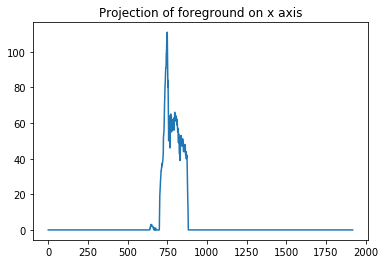

In [ ]:
plt.figure()
plt.title('Projection of foreground on x axis')
projX=np.sum(fg2[:,:],axis=0)
plt.plot(xpixel,projX)
xpos=np.argmax(projX)
print('xpos=',xpos)


ypos= 605


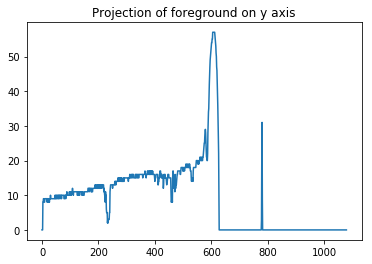

In [ ]:
plt.figure()
plt.title('Projection of foreground on y axis')
projY=np.sum(fg2[:,:],axis=1)
plt.plot(ypixel,projY)
ypos=np.argmax(projY)
print('ypos=',ypos)

And now let's see the next plot:

732.1148495632482 596.8540925266904 15.792975278307267 20.582758610547955


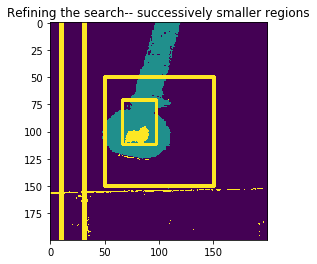

In [ ]:
bounds=(xpos-50,ypos-50, xpos+50,ypos+50)
xmean,ymean,xRMS,yRMS=GetFGMeans(bounds)
print(xmean,ymean,xRMS,yRMS)


cv2.circle(fgmask,(ypos,xpos), 4, (255,255,255), 2)
cv2.rectangle(fgmask,(bounds[0],bounds[1]),(bounds[2],bounds[3]),(255,255,255),2)
xmean,ymean,xRMS,yRMS=GetFGMeans(bounds)
bounds=([int(xmean-1.0*xRMS),int(ymean-1*yRMS), int(xmean+1*xRMS), int(ymean+1*yRMS)])
cv2.rectangle(fgmask,(bounds[0],bounds[1]),(bounds[2],bounds[3]),(255,255,255),2)
plt.figure()
plt.title('Refining the search-- successively smaller regions')
plt.imshow(fgmask[ypos-100:ypos+100,xpos-100:xpos+100])


xpos,ypos= 729 607
(array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
       30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]),)


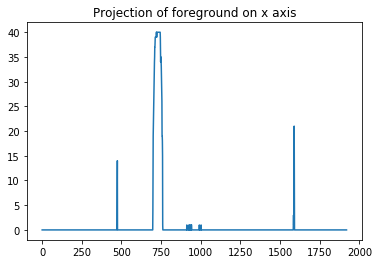

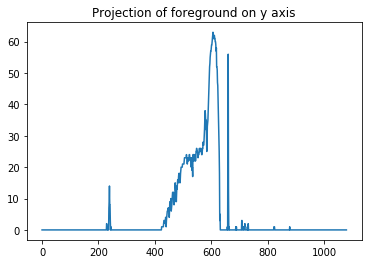

In [ ]:
plt.figure()
plt.title('Projection of foreground on x axis')
projX=np.sum(fg[ypos-20:ypos+20,:],axis=0)
plt.plot(xpixel,projX)
xx=np.where(projX>0.75*np.max(projX))
xpos=int(0.5*(xx[0][0]+xx[0][-1]))

plt.figure()
plt.title('Projection of foreground on y axis')
projY=np.sum(fg[:,xpos-40:xpos+40],axis=1)
plt.plot(ypixel,projY)
xx=np.where(projY[ypos-25:ypos+25]>0.75*np.max(projY))
ypos=ypos-25+int(0.5*(xx[0][0]+xx[0][-1]))
#ypos=np.argmax(projY)
print('xpos,ypos=',xpos,ypos)
print(xx)


729.0


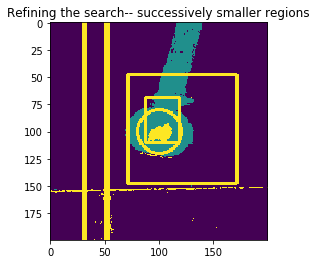

In [ ]:
xx=np.where(projX>0.75*np.max(projX))
print(0.5*(xx[0][0]+xx[0][-1]))
cv2.circle(fgmask,(xpos,ypos), 20, (255,255,255), 2)
plt.figure()
plt.title('Refining the search-- successively smaller regions')
plt.imshow(fgmask[ypos-100:ypos+100,xpos-100:xpos+100])

In [ ]:
firstFrame=1250
fgbg = cv2.createBackgroundSubtractorMOG2()
#Use first few frames to 'train' the background subtractor
for frameNumber in range(firstFrame,firstFrame+10):
    movie.set(cv2.CAP_PROP_POS_FRAMES,frameNumber)
    ret,frame=movie.read()
    fgmask=fgbg.apply(frame)

frameCount=0 #number of times FindBall is called
ny,nx=fgmask.shape  #note shape is rows, columns and counts from upper left in an image
xpixel=np.arange(0,nx)
ypixel=np.arange(0,ny)

def FindBall(frameNumber, draw=False):
    '''This function locates the ball in a frame and returns it central position in pixels.
    if draw is true it surrounds the ball with a rectangle and displays it'''
    global frameCount
    global movie
    global fgmask
    global fgbg
    global fg
    global oldxmean
    global oldymean
    movie.set(cv2.CAP_PROP_POS_FRAMES,frameNumber)
    ret,frame=movie.read()
    if not ret:
        return -99999

    print('framecount=',frameCount)
    fgmask=fgbg.apply(frame)

    fg=np.where(fgmask!=0,1,0)
    if draw:
        plt.figure()
        plt.title('Single frame, straight from camera')
        plt.imshow(frame)
        plt.figure()
        plt.title('Foreground mask: the part of the picture that is moving')
        plt.imshow(fg)

    fg2c=np.zeros_like(fg)
    fg2r=np.zeros_like(fg)
    i1=3
    i2=-4
    for i in range(-i1,-i2):
        fg2c[i1:i2,:]=fg2c[i1:i2,:]+fg[i1+i:i2+i,:]

    for i in range(-i1,-i2):
        fg2r[:,i1:i2]=fg2r[:,i1:i2]+fg2c[:,i1+i:i2+i]

#    fg2=np.zeros_like(fg)
    import pdb
    pdb.set_trace()
    fg2=np.where(fg2r>41,1,0)

    projX=np.sum(fg2[:,:],axis=0)
    xpos=np.argmax(projX)
    projY=np.sum(fg2[:,:],axis=1)
    ypos=np.argmax(projY)
    projX=np.sum(fg[ypos-20:ypos+20,:],axis=0)
    xx=np.where(projX>0.75*np.max(projX))
    xpos=int(0.5*(xx[0][0]+xx[0][-1]))
    projY=np.sum(fg[:,xpos-40:xpos+40],axis=1)
    xx=np.where(projY[ypos-25:ypos+25]>0.75*np.max(projY))
    if len(xx[0])==0:
        print (projY[ypos-25:ypos+25])
    print('ypos,xx=',ypos,xx,len(xx[0]))
    ypos=ypos-25+int(0.5*(xx[0][0]+xx[0][-1]))

    if draw:
        plt.figure()
        plt.title('Refining the search-- successively smaller regions')
        cv2.circle(fgmask,(xpos,ypos), 20, (255,255,255), 2)
        plt.imshow(fgmask[ypos-200:ypos+200,xpos-200:xpos+200])
    frameCount=frameCount+1
    return xpos,ypos



In [ ]:
FindBall(1288,True)

framecount= 0
> <ipython-input-37-68e8616176a6>(54)FindBall()
-> fg2=np.where(fg2r>41,1,0)
(Pdb) n
> <ipython-input-37-68e8616176a6>(56)FindBall()
-> projX=np.sum(fg2[:,:],axis=0)
(Pdb) n
> <ipython-input-37-68e8616176a6>(57)FindBall()
-> xpos=np.argmax(projX)
(Pdb) projX
array([0, 0, 0, ..., 0, 0, 0])
(Pdb) n
> <ipython-input-37-68e8616176a6>(58)FindBall()
-> projY=np.sum(fg2[:,:],axis=1)
(Pdb) xpos
905
(Pdb) n
> <ipython-input-37-68e8616176a6>(59)FindBall()
-> ypos=np.argmax(projY)
(Pdb) projX[905]
322
(Pdb) n
> <ipython-input-37-68e8616176a6>(60)FindBall()
-> projX=np.sum(fg[ypos-20:ypos+20,:],axis=0)
(Pdb) ypos
777
(Pdb) projY[777]
64
(Pdb) n
> <ipython-input-37-68e8616176a6>(61)FindBall()
-> xx=np.where(projX>0.75*np.max(projX))
(Pdb) n
> <ipython-input-37-68e8616176a6>(62)FindBall()
-> xpos=int(0.5*(xx[0][0]+xx[0][-1]))
(Pdb) xx
(array([1280]),)
(Pdb) n
> <ipython-input-37-68e8616176a6>(63)FindBall()
-> projY=np.sum(fg[:,xpos-40:xpos+40],axis=1)
(Pdb) xpos
1280


In [ ]:
start=1275

# Create a VideoWriter object to keep track of algorithm
fourcc = int(movie.get(cv2.CAP_PROP_FOURCC))
out = cv2.VideoWriter('output.mp4',fourcc, 30, (width,height),False)
time=np.linspace(0,(length-start)/fps,(length-start))
xp=np.zeros(len(time))
yp=np.zeros(len(time))
theta=np.zeros(len(time))
for fN in range(0,200):
    xp[fN],yp[fN]=FindBall(start+fN)
    print(xp[fN],yp[fN])
    out.write(fgmask)

out.release()


framecount= 1
ypos,xx= 293 (array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
       42, 43, 44]),) 37
162.0 294.0
framecount= 2
ypos,xx= 289 (array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
       42, 43]),) 36
160.0 289.0
framecount= 3
ypos,xx= 295 (array([ 8,  9, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 44, 45, 46]),) 28
171.0 297.0
framecount= 4
ypos,xx= 315 (array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39]),) 36
180.0 311.0
framecount= 5
ypos,xx= 320 (array([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),) 28
216.0 330.0
framecount= 6
ypos,

IndexError: index 0 is out of bounds for axis 0 with size 0

Looking at the movie, our background mask is picking up tiny lighting changes.  We rerun with a shorter history and a higher threshold

In [ ]:
aa=np.zeros(10)
len(aa)


10

In [ ]:
fgbg = cv2.createBackgroundSubtractorMOG2(200,40)
#Use first few frames to 'train' the background subtractor
for frameNumber in range(1290,1301):
    movie.set(cv2.CAP_PROP_POS_FRAMES,frameNumber)
    ret,frame=movie.read()
    fgmask=fgbg.apply(frame)
#h=TH2F('H','points',width,0,width,height,0,height)
#gr=TGraph()
#grxt=TGraph()
#gryt=TGraph()

frameCount=0 #number of times FindBall is called
start=1302

# Create a VideoWriter object to keep track of algorithm
fourcc = int(movie.get(cv2.CAP_PROP_FOURCC))
#fourcc=cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output2.mp4',fourcc, fps, (width,height),False)
time=np.linspace(0,(length-start)/fps,(length-start))
xpos=np.zeros(len(time))
ypos=np.zeros(len(time))
dx=np.zeros(len(time))
dy=np.zeros(len(time))
for fN in range(0,length-start):  #change to less than length for shorter analysis.
    xpos[fN],ypos[fN],dx[fN],dy[fN]=FindBall(start+fN)
    out.write(fgmask)

np.save('xpos',xpos)  #I have saved these by renaming them to xposLong and yposLong
np.save('ypos',ypos)
np.save('dx',dx)
np.save('dy',dy)
out.release()


framecount= 0
framecount= 1
framecount= 2
framecount= 3
framecount= 4
framecount= 5
framecount= 6
framecount= 7
framecount= 8
framecount= 9
framecount= 10
framecount= 11
framecount= 12
framecount= 13
framecount= 14
framecount= 15
framecount= 16
framecount= 17
framecount= 18
framecount= 19
framecount= 20
framecount= 21
framecount= 22
framecount= 23
framecount= 24
framecount= 25
framecount= 26
framecount= 27
framecount= 28
framecount= 29
framecount= 30
framecount= 31
framecount= 32
framecount= 33
framecount= 34
framecount= 35
framecount= 36
framecount= 37
framecount= 38
framecount= 39
framecount= 40
framecount= 41
framecount= 42
framecount= 43
framecount= 44
framecount= 45
framecount= 46
framecount= 47
framecount= 48
framecount= 49
framecount= 50
framecount= 51
framecount= 52
framecount= 53
framecount= 54
framecount= 55
framecount= 56
framecount= 57
framecount= 58
framecount= 59
framecount= 60
framecount= 61
framecount= 62
framecount= 63
framecount= 64
framecount= 65
framecount= 66
frame

framecount= 519
framecount= 520
framecount= 521
framecount= 522
framecount= 523
framecount= 524
framecount= 525
framecount= 526
framecount= 527
framecount= 528
framecount= 529
framecount= 530
framecount= 531
framecount= 532
framecount= 533
framecount= 534
framecount= 535
framecount= 536
framecount= 537
framecount= 538
framecount= 539
framecount= 540
framecount= 541
framecount= 542
framecount= 543
framecount= 544
framecount= 545
framecount= 546
framecount= 547
framecount= 548
framecount= 549
framecount= 550
framecount= 551
framecount= 552
framecount= 553
framecount= 554
framecount= 555
framecount= 556
framecount= 557
framecount= 558
framecount= 559
framecount= 560
framecount= 561
framecount= 562
framecount= 563
framecount= 564
framecount= 565
framecount= 566
framecount= 567
framecount= 568
framecount= 569
framecount= 570
framecount= 571
framecount= 572
framecount= 573
framecount= 574
framecount= 575
framecount= 576
framecount= 577
framecount= 578
framecount= 579
framecount= 580
framecou

framecount= 1030
framecount= 1031
framecount= 1032
framecount= 1033
framecount= 1034
framecount= 1035
framecount= 1036
framecount= 1037
framecount= 1038
framecount= 1039
framecount= 1040
framecount= 1041
framecount= 1042
framecount= 1043
framecount= 1044
framecount= 1045
framecount= 1046
framecount= 1047
framecount= 1048
framecount= 1049
framecount= 1050
framecount= 1051
framecount= 1052
framecount= 1053
framecount= 1054
framecount= 1055
framecount= 1056
framecount= 1057
framecount= 1058
framecount= 1059
framecount= 1060
framecount= 1061
framecount= 1062
framecount= 1063
framecount= 1064
framecount= 1065
framecount= 1066
framecount= 1067
framecount= 1068
framecount= 1069
framecount= 1070
framecount= 1071
framecount= 1072
framecount= 1073
framecount= 1074
framecount= 1075
framecount= 1076
framecount= 1077
framecount= 1078
framecount= 1079
framecount= 1080
framecount= 1081
framecount= 1082
framecount= 1083
framecount= 1084
framecount= 1085
framecount= 1086
framecount= 1087
framecount= 10

framecount= 1513
framecount= 1514
framecount= 1515
framecount= 1516
framecount= 1517
framecount= 1518
framecount= 1519
framecount= 1520
framecount= 1521
framecount= 1522
framecount= 1523
framecount= 1524
framecount= 1525
framecount= 1526
framecount= 1527
framecount= 1528
framecount= 1529
framecount= 1530
framecount= 1531
framecount= 1532
framecount= 1533
framecount= 1534
framecount= 1535
framecount= 1536
framecount= 1537
framecount= 1538
framecount= 1539
framecount= 1540
framecount= 1541
framecount= 1542
framecount= 1543
framecount= 1544
framecount= 1545
framecount= 1546
framecount= 1547
framecount= 1548
framecount= 1549
framecount= 1550
framecount= 1551
framecount= 1552
framecount= 1553
framecount= 1554
framecount= 1555
framecount= 1556
framecount= 1557
framecount= 1558
framecount= 1559
framecount= 1560
framecount= 1561
framecount= 1562
framecount= 1563
framecount= 1564
framecount= 1565
framecount= 1566
framecount= 1567
framecount= 1568
framecount= 1569
framecount= 1570
framecount= 15

framecount= 1996
framecount= 1997
framecount= 1998
framecount= 1999
framecount= 2000
framecount= 2001
framecount= 2002
framecount= 2003
framecount= 2004
framecount= 2005
framecount= 2006
framecount= 2007
framecount= 2008
framecount= 2009
framecount= 2010
framecount= 2011
framecount= 2012
framecount= 2013
framecount= 2014
framecount= 2015
framecount= 2016
framecount= 2017
framecount= 2018
framecount= 2019
framecount= 2020
framecount= 2021
framecount= 2022
framecount= 2023
framecount= 2024
framecount= 2025
framecount= 2026
framecount= 2027
framecount= 2028
framecount= 2029
framecount= 2030
framecount= 2031
framecount= 2032
framecount= 2033
framecount= 2034
framecount= 2035
framecount= 2036
framecount= 2037
framecount= 2038
framecount= 2039
framecount= 2040
framecount= 2041
framecount= 2042
framecount= 2043
framecount= 2044
framecount= 2045
framecount= 2046
framecount= 2047
framecount= 2048
framecount= 2049
framecount= 2050
framecount= 2051
framecount= 2052
framecount= 2053
framecount= 20

framecount= 2478
framecount= 2479
framecount= 2480
framecount= 2481
framecount= 2482
framecount= 2483
framecount= 2484
framecount= 2485
framecount= 2486
framecount= 2487
framecount= 2488
framecount= 2489
framecount= 2490
framecount= 2491
framecount= 2492
framecount= 2493
framecount= 2494
framecount= 2495
framecount= 2496
framecount= 2497
framecount= 2498
framecount= 2499
framecount= 2500
framecount= 2501
framecount= 2502
framecount= 2503
framecount= 2504
framecount= 2505
framecount= 2506
framecount= 2507
framecount= 2508
framecount= 2509
framecount= 2510
framecount= 2511
framecount= 2512
framecount= 2513
framecount= 2514
framecount= 2515
framecount= 2516
framecount= 2517
framecount= 2518
framecount= 2519
framecount= 2520
framecount= 2521
framecount= 2522
framecount= 2523
framecount= 2524
framecount= 2525
framecount= 2526
framecount= 2527
framecount= 2528
framecount= 2529
framecount= 2530
framecount= 2531
framecount= 2532
framecount= 2533
framecount= 2534
framecount= 2535
framecount= 25

framecount= 2961
framecount= 2962
framecount= 2963
framecount= 2964
framecount= 2965
framecount= 2966
framecount= 2967
framecount= 2968
framecount= 2969
framecount= 2970
framecount= 2971
framecount= 2972
framecount= 2973
framecount= 2974
framecount= 2975
framecount= 2976
framecount= 2977
framecount= 2978
framecount= 2979
framecount= 2980
framecount= 2981
framecount= 2982
framecount= 2983
framecount= 2984
framecount= 2985
framecount= 2986
framecount= 2987
framecount= 2988
framecount= 2989
framecount= 2990
framecount= 2991
framecount= 2992
framecount= 2993
framecount= 2994
framecount= 2995
framecount= 2996
framecount= 2997
framecount= 2998
framecount= 2999
framecount= 3000
framecount= 3001
framecount= 3002
framecount= 3003
framecount= 3004
framecount= 3005
framecount= 3006
framecount= 3007
framecount= 3008
framecount= 3009
framecount= 3010
framecount= 3011
framecount= 3012
framecount= 3013
framecount= 3014
framecount= 3015
framecount= 3016
framecount= 3017
framecount= 3018
framecount= 30

framecount= 3444
framecount= 3445
framecount= 3446
framecount= 3447
framecount= 3448
framecount= 3449
framecount= 3450
framecount= 3451
framecount= 3452
framecount= 3453
framecount= 3454
framecount= 3455
framecount= 3456
framecount= 3457
framecount= 3458
framecount= 3459
framecount= 3460
framecount= 3461
framecount= 3462
framecount= 3463
framecount= 3464
framecount= 3465
framecount= 3466
framecount= 3467
framecount= 3468
framecount= 3469
framecount= 3470
framecount= 3471
framecount= 3472
framecount= 3473
framecount= 3474
framecount= 3475
framecount= 3476
framecount= 3477
framecount= 3478
framecount= 3479
framecount= 3480
framecount= 3481
framecount= 3482
framecount= 3483
framecount= 3484
framecount= 3485
framecount= 3486
framecount= 3487
framecount= 3488
framecount= 3489
framecount= 3490
framecount= 3491
framecount= 3492
framecount= 3493
framecount= 3494
framecount= 3495
framecount= 3496
framecount= 3497
framecount= 3498
framecount= 3499
framecount= 3500
framecount= 3501
framecount= 35

framecount= 3926
framecount= 3927
framecount= 3928
framecount= 3929
framecount= 3930
framecount= 3931
framecount= 3932
framecount= 3933
framecount= 3934
framecount= 3935
framecount= 3936
framecount= 3937
framecount= 3938
framecount= 3939
framecount= 3940
framecount= 3941
framecount= 3942
framecount= 3943
framecount= 3944
framecount= 3945
framecount= 3946
framecount= 3947
framecount= 3948
framecount= 3949
framecount= 3950
framecount= 3951
framecount= 3952
framecount= 3953
framecount= 3954
framecount= 3955
framecount= 3956
framecount= 3957
framecount= 3958
framecount= 3959
framecount= 3960
framecount= 3961
framecount= 3962
framecount= 3963
framecount= 3964
framecount= 3965
framecount= 3966
framecount= 3967
framecount= 3968
framecount= 3969
framecount= 3970
framecount= 3971
framecount= 3972
framecount= 3973
framecount= 3974
framecount= 3975
framecount= 3976
framecount= 3977
framecount= 3978
framecount= 3979
framecount= 3980
framecount= 3981
framecount= 3982
framecount= 3983
framecount= 39

framecount= 4409
framecount= 4410
framecount= 4411
framecount= 4412
framecount= 4413
framecount= 4414
framecount= 4415
framecount= 4416
framecount= 4417
framecount= 4418
framecount= 4419
framecount= 4420
framecount= 4421
framecount= 4422
framecount= 4423
framecount= 4424
framecount= 4425
framecount= 4426
framecount= 4427
framecount= 4428
framecount= 4429
framecount= 4430
framecount= 4431
framecount= 4432
framecount= 4433
framecount= 4434
framecount= 4435
framecount= 4436
framecount= 4437
framecount= 4438
framecount= 4439
framecount= 4440
framecount= 4441
framecount= 4442
framecount= 4443
framecount= 4444
framecount= 4445
framecount= 4446
framecount= 4447
framecount= 4448
framecount= 4449
framecount= 4450
framecount= 4451
framecount= 4452
framecount= 4453
framecount= 4454
framecount= 4455
framecount= 4456
framecount= 4457
framecount= 4458
framecount= 4459
framecount= 4460
framecount= 4461
framecount= 4462
framecount= 4463
framecount= 4464
framecount= 4465
framecount= 4466
framecount= 44

framecount= 4892
framecount= 4893
framecount= 4894
framecount= 4895
framecount= 4896
framecount= 4897
framecount= 4898
framecount= 4899
framecount= 4900
framecount= 4901
framecount= 4902
framecount= 4903
framecount= 4904
framecount= 4905
framecount= 4906
framecount= 4907
framecount= 4908
framecount= 4909
framecount= 4910
framecount= 4911
framecount= 4912
framecount= 4913
framecount= 4914
framecount= 4915
framecount= 4916
framecount= 4917
framecount= 4918
framecount= 4919
framecount= 4920
framecount= 4921
framecount= 4922
framecount= 4923
framecount= 4924
framecount= 4925
framecount= 4926
framecount= 4927
framecount= 4928
framecount= 4929
framecount= 4930
framecount= 4931
framecount= 4932
framecount= 4933
framecount= 4934
framecount= 4935
framecount= 4936
framecount= 4937
framecount= 4938
framecount= 4939
framecount= 4940
framecount= 4941
framecount= 4942
framecount= 4943
framecount= 4944
framecount= 4945
framecount= 4946
framecount= 4947
framecount= 4948
framecount= 4949
framecount= 49

framecount= 5374
framecount= 5375
framecount= 5376
framecount= 5377
framecount= 5378
framecount= 5379
framecount= 5380
framecount= 5381
framecount= 5382
framecount= 5383
framecount= 5384
framecount= 5385
framecount= 5386
framecount= 5387
framecount= 5388
framecount= 5389
framecount= 5390
framecount= 5391
framecount= 5392
framecount= 5393
framecount= 5394
framecount= 5395
framecount= 5396
framecount= 5397
framecount= 5398
framecount= 5399
framecount= 5400
framecount= 5401
framecount= 5402
framecount= 5403
framecount= 5404
framecount= 5405
framecount= 5406
framecount= 5407
framecount= 5408
framecount= 5409
framecount= 5410
framecount= 5411
framecount= 5412
framecount= 5413
framecount= 5414
framecount= 5415
framecount= 5416
framecount= 5417
framecount= 5418
framecount= 5419
framecount= 5420
framecount= 5421
framecount= 5422
framecount= 5423
framecount= 5424
framecount= 5425
framecount= 5426
framecount= 5427
framecount= 5428
framecount= 5429
framecount= 5430
framecount= 5431
framecount= 54

framecount= 5857
framecount= 5858
framecount= 5859
framecount= 5860
framecount= 5861
framecount= 5862
framecount= 5863
framecount= 5864
framecount= 5865
framecount= 5866
framecount= 5867
framecount= 5868
framecount= 5869
framecount= 5870
framecount= 5871
framecount= 5872
framecount= 5873
framecount= 5874
framecount= 5875
framecount= 5876
framecount= 5877
framecount= 5878
framecount= 5879
framecount= 5880
framecount= 5881
framecount= 5882
framecount= 5883
framecount= 5884
framecount= 5885
framecount= 5886
framecount= 5887
framecount= 5888
framecount= 5889
framecount= 5890
framecount= 5891
framecount= 5892
framecount= 5893
framecount= 5894
framecount= 5895
framecount= 5896
framecount= 5897
framecount= 5898
framecount= 5899
framecount= 5900
framecount= 5901
framecount= 5902
framecount= 5903
framecount= 5904
framecount= 5905
framecount= 5906
framecount= 5907
framecount= 5908
framecount= 5909
framecount= 5910
framecount= 5911
framecount= 5912
framecount= 5913
framecount= 5914
framecount= 59

framecount= 6339
framecount= 6340
framecount= 6341
framecount= 6342
framecount= 6343
framecount= 6344
framecount= 6345
framecount= 6346
framecount= 6347
framecount= 6348
framecount= 6349
framecount= 6350
framecount= 6351
framecount= 6352
framecount= 6353
framecount= 6354
framecount= 6355
framecount= 6356
framecount= 6357
framecount= 6358
framecount= 6359
framecount= 6360
framecount= 6361
framecount= 6362
framecount= 6363
framecount= 6364
framecount= 6365
framecount= 6366
framecount= 6367
framecount= 6368
framecount= 6369
framecount= 6370
framecount= 6371
framecount= 6372
framecount= 6373
framecount= 6374
framecount= 6375
framecount= 6376
framecount= 6377
framecount= 6378
framecount= 6379
framecount= 6380
framecount= 6381
framecount= 6382
framecount= 6383
framecount= 6384
framecount= 6385
framecount= 6386
framecount= 6387
framecount= 6388
framecount= 6389
framecount= 6390
framecount= 6391
framecount= 6392
framecount= 6393
framecount= 6394
framecount= 6395
framecount= 6396
framecount= 63

framecount= 6768
framecount= 6769
framecount= 6770
framecount= 6771
framecount= 6772
framecount= 6773
framecount= 6774
framecount= 6775
framecount= 6776
framecount= 6777
framecount= 6778
framecount= 6779
framecount= 6780
framecount= 6781
framecount= 6782
framecount= 6783
framecount= 6784
framecount= 6785
framecount= 6786
framecount= 6787
framecount= 6788
framecount= 6789
framecount= 6790
framecount= 6791
framecount= 6792
framecount= 6793
framecount= 6794
framecount= 6795
framecount= 6796
framecount= 6797
framecount= 6798
framecount= 6799
framecount= 6800
framecount= 6801
framecount= 6802
framecount= 6803
framecount= 6804
framecount= 6805
framecount= 6806
framecount= 6807
framecount= 6808
framecount= 6809
framecount= 6810
framecount= 6811
framecount= 6812
framecount= 6813
framecount= 6814
framecount= 6815
framecount= 6816
framecount= 6817
framecount= 6818
framecount= 6819
framecount= 6820
framecount= 6821
framecount= 6822
framecount= 6823
framecount= 6824
framecount= 6825
framecount= 68

framecount= 7199
framecount= 7200
framecount= 7201
framecount= 7202
framecount= 7203
framecount= 7204
framecount= 7205
framecount= 7206
framecount= 7207
framecount= 7208
framecount= 7209
framecount= 7210
framecount= 7211
framecount= 7212
framecount= 7213
framecount= 7214
framecount= 7215
framecount= 7216
framecount= 7217
framecount= 7218
framecount= 7219
framecount= 7220
framecount= 7221
framecount= 7222
framecount= 7223
framecount= 7224
framecount= 7225
framecount= 7226
framecount= 7227
framecount= 7228
framecount= 7229
framecount= 7230
framecount= 7231
framecount= 7232
framecount= 7233
framecount= 7234
framecount= 7235
framecount= 7236
framecount= 7237
framecount= 7238
framecount= 7239
framecount= 7240
framecount= 7241
framecount= 7242
framecount= 7243
framecount= 7244
framecount= 7245
framecount= 7246
framecount= 7247
framecount= 7248
framecount= 7249
framecount= 7250
framecount= 7251
framecount= 7252
framecount= 7253
framecount= 7254
framecount= 7255
framecount= 7256
framecount= 72

framecount= 7682
framecount= 7683
framecount= 7684
framecount= 7685
framecount= 7686
framecount= 7687
framecount= 7688
framecount= 7689
framecount= 7690
framecount= 7691
framecount= 7692
framecount= 7693
framecount= 7694
framecount= 7695
framecount= 7696
framecount= 7697
framecount= 7698
framecount= 7699
framecount= 7700
framecount= 7701
framecount= 7702
framecount= 7703
framecount= 7704
framecount= 7705
framecount= 7706
framecount= 7707
framecount= 7708
framecount= 7709
framecount= 7710
framecount= 7711
framecount= 7712
framecount= 7713
framecount= 7714
framecount= 7715
framecount= 7716
framecount= 7717
framecount= 7718
framecount= 7719
framecount= 7720
framecount= 7721
framecount= 7722
framecount= 7723
framecount= 7724
framecount= 7725
framecount= 7726
framecount= 7727
framecount= 7728
framecount= 7729
framecount= 7730
framecount= 7731
framecount= 7732
framecount= 7733
framecount= 7734
framecount= 7735
framecount= 7736
framecount= 7737
framecount= 7738
framecount= 7739
framecount= 77

framecount= 8164
framecount= 8165
framecount= 8166
framecount= 8167
framecount= 8168
framecount= 8169
framecount= 8170
framecount= 8171
framecount= 8172
framecount= 8173
framecount= 8174
framecount= 8175
framecount= 8176
framecount= 8177
framecount= 8178
framecount= 8179
framecount= 8180
framecount= 8181
framecount= 8182
framecount= 8183
framecount= 8184
framecount= 8185
framecount= 8186
framecount= 8187
framecount= 8188
framecount= 8189
framecount= 8190
framecount= 8191
framecount= 8192
framecount= 8193
framecount= 8194
framecount= 8195
framecount= 8196
framecount= 8197
framecount= 8198
framecount= 8199
framecount= 8200
framecount= 8201
framecount= 8202
framecount= 8203
framecount= 8204
framecount= 8205
framecount= 8206
framecount= 8207
framecount= 8208
framecount= 8209
framecount= 8210
framecount= 8211
framecount= 8212
framecount= 8213
framecount= 8214
framecount= 8215
framecount= 8216
framecount= 8217
framecount= 8218
framecount= 8219
framecount= 8220
framecount= 8221
framecount= 82

framecount= 8647
framecount= 8648
framecount= 8649
framecount= 8650
framecount= 8651
framecount= 8652
framecount= 8653
framecount= 8654
framecount= 8655
framecount= 8656
framecount= 8657
framecount= 8658
framecount= 8659
framecount= 8660
framecount= 8661
framecount= 8662
framecount= 8663
framecount= 8664
framecount= 8665
framecount= 8666
framecount= 8667
framecount= 8668
framecount= 8669
framecount= 8670
framecount= 8671
framecount= 8672
framecount= 8673
framecount= 8674
framecount= 8675
framecount= 8676
framecount= 8677
framecount= 8678
framecount= 8679
framecount= 8680
framecount= 8681
framecount= 8682
framecount= 8683
framecount= 8684
framecount= 8685
framecount= 8686
framecount= 8687
framecount= 8688
framecount= 8689
framecount= 8690
framecount= 8691
framecount= 8692
framecount= 8693
framecount= 8694
framecount= 8695
framecount= 8696
framecount= 8697
framecount= 8698
framecount= 8699
framecount= 8700
framecount= 8701
framecount= 8702
framecount= 8703
framecount= 8704
framecount= 87

framecount= 9118
framecount= 9119
framecount= 9120
framecount= 9121
framecount= 9122
framecount= 9123
framecount= 9124
framecount= 9125
framecount= 9126
framecount= 9127
framecount= 9128
framecount= 9129
framecount= 9130
framecount= 9131
framecount= 9132
framecount= 9133
framecount= 9134
framecount= 9135
framecount= 9136
framecount= 9137
framecount= 9138
framecount= 9139
framecount= 9140
framecount= 9141
framecount= 9142
framecount= 9143
framecount= 9144
-389 1988 -206 1049 0 0 [[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
-2 2 -2 2 0 0 []
framecount= 9145
framecount= 9146
framecount= 9147
framecount= 9148
framecount= 9149
framecount= 9150
framecount= 9151
framecount= 9152
framecount= 9153
framecount= 9154
framecount= 9155
framecount= 9156
framecount= 9157
framecount= 9158
framecount= 9159
framecount= 9160
framecount= 9161
framecount= 9162
framecount= 9163
framecount= 9164
framecount= 9165
framecount= 916

framecount= 9524
framecount= 9525
framecount= 9526
framecount= 9527
framecount= 9528
framecount= 9529
framecount= 9530
framecount= 9531
framecount= 9532
framecount= 9533
framecount= 9534
framecount= 9535
framecount= 9536
framecount= 9537
framecount= 9538
framecount= 9539
framecount= 9540
framecount= 9541
framecount= 9542
framecount= 9543
framecount= 9544
framecount= 9545
-51 1977 1046 1077 0 0 [[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
-2 2 -2 2 0 0 []
framecount= 9546
-352 1479 357 865 0 0 []
-2 2 -2 2 0 0 []
framecount= 9547
-313 1403 363 867 0 0 []
-2 2 -2 2 0 0 []
framecount= 9548
-337 1512 334 881 0 0 []
-2 2 -2 2 0 0 []
framecount= 9549
-355 1551 335 877 0 0 []
-2 2 -2 2 0 0 []
framecount= 9550
-313 1440 334 891 0 0 []
-2 2 -2 2 0 0 []
framecount= 9551
-233 1228 356 863 0 0 []
-2 2 -2 2 0 0 []
framecount= 9552
-226 1216 395 833 0 0 []
-2 2 -2 2 0 0 []
framecount= 9553
-220 1219 410 792 0 0 []
-2 

framecount= 9882
framecount= 9883
framecount= 9884
framecount= 9885
framecount= 9886
framecount= 9887
framecount= 9888
framecount= 9889
framecount= 9890
framecount= 9891
framecount= 9892
framecount= 9893
framecount= 9894
framecount= 9895
framecount= 9896
framecount= 9897
framecount= 9898
framecount= 9899
framecount= 9900
framecount= 9901
framecount= 9902
framecount= 9903
framecount= 9904
framecount= 9905
framecount= 9906
framecount= 9907
framecount= 9908
framecount= 9909
framecount= 9910
framecount= 9911
framecount= 9912
framecount= 9913
framecount= 9914
framecount= 9915
framecount= 9916
framecount= 9917
framecount= 9918
framecount= 9919
framecount= 9920
framecount= 9921
framecount= 9922
framecount= 9923
framecount= 9924
framecount= 9925
framecount= 9926
framecount= 9927
framecount= 9928
framecount= 9929
framecount= 9930
framecount= 9931
framecount= 9932
framecount= 9933
framecount= 9934
framecount= 9935
framecount= 9936
framecount= 9937
framecount= 9938
framecount= 9939
framecount= 99

framecount= 10331
framecount= 10332
framecount= 10333
framecount= 10334
framecount= 10335
framecount= 10336
framecount= 10337
framecount= 10338
framecount= 10339
framecount= 10340
framecount= 10341
framecount= 10342
framecount= 10343
framecount= 10344
framecount= 10345
framecount= 10346
framecount= 10347
framecount= 10348
framecount= 10349
framecount= 10350
framecount= 10351
framecount= 10352
framecount= 10353
framecount= 10354
framecount= 10355
framecount= 10356
framecount= 10357
framecount= 10358
framecount= 10359
framecount= 10360
framecount= 10361
framecount= 10362
framecount= 10363
framecount= 10364
framecount= 10365
framecount= 10366
framecount= 10367
framecount= 10368
framecount= 10369
framecount= 10370
framecount= 10371
framecount= 10372
framecount= 10373
framecount= 10374
framecount= 10375
framecount= 10376
framecount= 10377
framecount= 10378
framecount= 10379
framecount= 10380
framecount= 10381
framecount= 10382
framecount= 10383
framecount= 10384
framecount= 10385
framecount

framecount= 10787
framecount= 10788
framecount= 10789
framecount= 10790
framecount= 10791
framecount= 10792
framecount= 10793
framecount= 10794
framecount= 10795
framecount= 10796
framecount= 10797
framecount= 10798
framecount= 10799
framecount= 10800
framecount= 10801
framecount= 10802
framecount= 10803
framecount= 10804
framecount= 10805
framecount= 10806
framecount= 10807
framecount= 10808
framecount= 10809
framecount= 10810
framecount= 10811
framecount= 10812
framecount= 10813
framecount= 10814
framecount= 10815
framecount= 10816
framecount= 10817
framecount= 10818
framecount= 10819
framecount= 10820
framecount= 10821
framecount= 10822
framecount= 10823
framecount= 10824
framecount= 10825
framecount= 10826
framecount= 10827
framecount= 10828
framecount= 10829
framecount= 10830
framecount= 10831
framecount= 10832
framecount= 10833
framecount= 10834
framecount= 10835
framecount= 10836
framecount= 10837
framecount= 10838
framecount= 10839
framecount= 10840
framecount= 10841
framecount

framecount= 11243
framecount= 11244
framecount= 11245
framecount= 11246
framecount= 11247
framecount= 11248
framecount= 11249
framecount= 11250
framecount= 11251
framecount= 11252
framecount= 11253
framecount= 11254
framecount= 11255
framecount= 11256
framecount= 11257
framecount= 11258
framecount= 11259
framecount= 11260
framecount= 11261
framecount= 11262
framecount= 11263
framecount= 11264
framecount= 11265
framecount= 11266
framecount= 11267
framecount= 11268
framecount= 11269
framecount= 11270
framecount= 11271
framecount= 11272
framecount= 11273
framecount= 11274
framecount= 11275
framecount= 11276
framecount= 11277
framecount= 11278
framecount= 11279
framecount= 11280
framecount= 11281
framecount= 11282
framecount= 11283
framecount= 11284
framecount= 11285
framecount= 11286
framecount= 11287
framecount= 11288
framecount= 11289
framecount= 11290
framecount= 11291
framecount= 11292
framecount= 11293
framecount= 11294
framecount= 11295
framecount= 11296
framecount= 11297
framecount

framecount= 11699
framecount= 11700
framecount= 11701
framecount= 11702
framecount= 11703
framecount= 11704
framecount= 11705
framecount= 11706
framecount= 11707
framecount= 11708
framecount= 11709
framecount= 11710
framecount= 11711
framecount= 11712
framecount= 11713
framecount= 11714
framecount= 11715
framecount= 11716
framecount= 11717
framecount= 11718
framecount= 11719
framecount= 11720
framecount= 11721
framecount= 11722
framecount= 11723
framecount= 11724
framecount= 11725
framecount= 11726
framecount= 11727
framecount= 11728
framecount= 11729
framecount= 11730
framecount= 11731
framecount= 11732
framecount= 11733
framecount= 11734
framecount= 11735
framecount= 11736
framecount= 11737
framecount= 11738
framecount= 11739
framecount= 11740
framecount= 11741
framecount= 11742
framecount= 11743
framecount= 11744
framecount= 11745
framecount= 11746
framecount= 11747
framecount= 11748
framecount= 11749
framecount= 11750
framecount= 11751
framecount= 11752
framecount= 11753
framecount

framecount= 12156
framecount= 12157
framecount= 12158
framecount= 12159
framecount= 12160
framecount= 12161
framecount= 12162
framecount= 12163
405 744 -10 248 0 0 []
-2 2 -2 2 0 0 []
framecount= 12164
-73 1008 19 613 0 0 []
-2 2 -2 2 0 0 []
framecount= 12165
-140 1081 -11 679 0 0 []
-2 2 -2 2 0 0 []
framecount= 12166
-410 1297 108 799 0 0 []
-2 2 -2 2 0 0 []
framecount= 12167
-539 1428 304 752 0 0 [[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
-2 2 -2 2 0 0 []
framecount= 12168
-549 1462 312 751 0 0 [[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
-2 2 -2 2 0 0 []
framecount= 12169
-548 1513 316 755 0 0 [[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
-2 2 -2 2 0 0 []
framecount= 12170
-550 1558 323 755 0 0 [[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0

framecount= 12479
framecount= 12480
framecount= 12481
framecount= 12482
framecount= 12483
framecount= 12484
framecount= 12485
framecount= 12486
framecount= 12487
framecount= 12488
framecount= 12489
framecount= 12490
framecount= 12491
framecount= 12492
framecount= 12493
framecount= 12494
framecount= 12495
framecount= 12496
framecount= 12497
framecount= 12498
framecount= 12499
framecount= 12500
framecount= 12501
framecount= 12502
framecount= 12503
framecount= 12504
framecount= 12505
framecount= 12506
framecount= 12507
framecount= 12508
framecount= 12509
framecount= 12510
framecount= 12511
framecount= 12512
framecount= 12513
framecount= 12514
framecount= 12515
framecount= 12516
framecount= 12517
framecount= 12518
framecount= 12519
framecount= 12520
framecount= 12521
framecount= 12522
framecount= 12523
framecount= 12524
framecount= 12525
framecount= 12526
framecount= 12527
framecount= 12528
framecount= 12529
framecount= 12530
framecount= 12531
framecount= 12532
framecount= 12533
framecount

framecount= 12916
framecount= 12917
framecount= 12918
framecount= 12919
framecount= 12920
framecount= 12921
framecount= 12922
framecount= 12923
framecount= 12924
framecount= 12925
framecount= 12926
framecount= 12927
framecount= 12928
framecount= 12929
framecount= 12930
framecount= 12931
framecount= 12932
framecount= 12933
framecount= 12934
framecount= 12935
framecount= 12936
framecount= 12937
framecount= 12938
framecount= 12939
framecount= 12940
framecount= 12941
framecount= 12942
framecount= 12943
framecount= 12944
framecount= 12945
framecount= 12946
framecount= 12947
framecount= 12948
framecount= 12949
framecount= 12950
framecount= 12951
framecount= 12952
framecount= 12953
framecount= 12954
framecount= 12955
framecount= 12956
framecount= 12957
framecount= 12958
framecount= 12959
framecount= 12960
framecount= 12961
framecount= 12962
framecount= 12963
framecount= 12964
framecount= 12965
framecount= 12966
framecount= 12967
framecount= 12968
framecount= 12969
framecount= 12970
framecount

framecount= 13351
framecount= 13352
framecount= 13353
framecount= 13354
framecount= 13355
framecount= 13356
framecount= 13357
framecount= 13358
framecount= 13359
framecount= 13360
framecount= 13361
framecount= 13362
framecount= 13363
framecount= 13364
framecount= 13365
framecount= 13366
framecount= 13367
framecount= 13368
framecount= 13369
framecount= 13370
framecount= 13371
framecount= 13372
framecount= 13373
framecount= 13374
framecount= 13375
framecount= 13376
framecount= 13377
framecount= 13378
framecount= 13379
framecount= 13380
framecount= 13381
framecount= 13382
framecount= 13383
framecount= 13384
framecount= 13385
framecount= 13386
framecount= 13387
framecount= 13388
1082 1192 -36 793 0 0 []
-2 2 -2 2 0 0 []
framecount= 13389
1078 1186 -43 828 0 0 []
-2 2 -2 2 0 0 []
framecount= 13390
1072 1180 -57 868 0 0 []
-2 2 -2 2 0 0 []
framecount= 13391
framecount= 13392
framecount= 13393
framecount= 13394
framecount= 13395
framecount= 13396
framecount= 13397
framecount= 13398
framecount

1074 1183 -79 807 0 0 []
-2 2 -2 2 0 0 []
framecount= 13726
1068 1178 -102 849 0 0 []
-2 2 -2 2 0 0 []
framecount= 13727
1067 1169 -62 876 0 0 []
-2 2 -2 2 0 0 []
framecount= 13728
framecount= 13729
framecount= 13730
framecount= 13731
framecount= 13732
framecount= 13733
framecount= 13734
framecount= 13735
framecount= 13736
framecount= 13737
framecount= 13738
framecount= 13739
framecount= 13740
framecount= 13741
framecount= 13742
framecount= 13743
framecount= 13744
framecount= 13745
framecount= 13746
framecount= 13747
framecount= 13748
framecount= 13749
framecount= 13750
framecount= 13751
framecount= 13752
framecount= 13753
framecount= 13754
framecount= 13755
framecount= 13756
framecount= 13757
framecount= 13758
framecount= 13759
framecount= 13760
framecount= 13761
framecount= 13762
framecount= 13763
framecount= 13764
framecount= 13765
framecount= 13766
framecount= 13767
framecount= 13768
framecount= 13769
framecount= 13770
framecount= 13771
framecount= 13772
1078 1190 -57 782 0 0 []
-2

framecount= 14101
framecount= 14102
framecount= 14103
framecount= 14104
framecount= 14105
framecount= 14106
framecount= 14107
framecount= 14108
1082 1188 -6 777 0 0 []
-2 2 -2 2 0 0 []
framecount= 14109
1072 1179 -87 783 0 0 []
-2 2 -2 2 0 0 []
framecount= 14110
1068 1172 -100 812 0 0 []
-2 2 -2 2 0 0 []
framecount= 14111
1072 1167 -27 853 0 0 []
-2 2 -2 2 0 0 []
framecount= 14112
framecount= 14113
framecount= 14114
framecount= 14115
framecount= 14116
framecount= 14117
framecount= 14118
framecount= 14119
framecount= 14120
framecount= 14121
framecount= 14122
framecount= 14123
framecount= 14124
framecount= 14125
framecount= 14126
framecount= 14127
framecount= 14128
framecount= 14129
framecount= 14130
framecount= 14131
framecount= 14132
framecount= 14133
framecount= 14134
framecount= 14135
framecount= 14136
framecount= 14137
framecount= 14138
framecount= 14139
framecount= 14140
framecount= 14141
framecount= 14142
framecount= 14143
framecount= 14144
framecount= 14145
framecount= 14146
fram

1071 1164 -38 831 0 0 []
-2 2 -2 2 0 0 []
framecount= 14448
1067 1156 -23 863 0 0 []
-2 2 -2 2 0 0 []
framecount= 14449
framecount= 14450
framecount= 14451
framecount= 14452
framecount= 14453
framecount= 14454
framecount= 14455
framecount= 14456
framecount= 14457
framecount= 14458
framecount= 14459
framecount= 14460
framecount= 14461
framecount= 14462
framecount= 14463
framecount= 14464
framecount= 14465
framecount= 14466
framecount= 14467
framecount= 14468
framecount= 14469
framecount= 14470
framecount= 14471
framecount= 14472
framecount= 14473
framecount= 14474
framecount= 14475
framecount= 14476
framecount= 14477
framecount= 14478
framecount= 14479
framecount= 14480
framecount= 14481
framecount= 14482
framecount= 14483
framecount= 14484
framecount= 14485
framecount= 14486
framecount= 14487
framecount= 14488
framecount= 14489
framecount= 14490
1073 1190 -63 798 0 0 []
-2 2 -2 2 0 0 []
framecount= 14491
1073 1189 -64 794 0 0 []
-2 2 -2 2 0 0 []
framecount= 14492
1076 1184 -41 776 0 0 

1058 1145 -81 876 0 0 []
-2 2 -2 2 0 0 []
framecount= 14786
framecount= 14787
framecount= 14788
framecount= 14789
framecount= 14790
framecount= 14791
framecount= 14792
framecount= 14793
framecount= 14794
framecount= 14795
framecount= 14796
framecount= 14797
framecount= 14798
framecount= 14799
framecount= 14800
framecount= 14801
framecount= 14802
framecount= 14803
framecount= 14804
framecount= 14805
framecount= 14806
framecount= 14807
framecount= 14808
framecount= 14809
framecount= 14810
framecount= 14811
framecount= 14812
framecount= 14813
framecount= 14814
framecount= 14815
framecount= 14816
framecount= 14817
framecount= 14818
framecount= 14819
framecount= 14820
framecount= 14821
framecount= 14822
framecount= 14823
framecount= 14824
1075 1172 -3 797 0 0 []
-2 2 -2 2 0 0 []
framecount= 14825
1076 1180 -9 795 0 0 []
-2 2 -2 2 0 0 []
framecount= 14826
1070 1184 -69 798 0 0 []
-2 2 -2 2 0 0 []
framecount= 14827
1072 1184 -62 793 0 0 []
-2 2 -2 2 0 0 []
framecount= 14828
1077 1181 -18 780 

framecount= 15086
framecount= 15087
framecount= 15088
framecount= 15089
framecount= 15090
framecount= 15091
framecount= 15092
framecount= 15093
framecount= 15094
framecount= 15095
framecount= 15096
framecount= 15097
framecount= 15098
framecount= 15099
framecount= 15100
framecount= 15101
framecount= 15102
framecount= 15103
framecount= 15104
framecount= 15105
framecount= 15106
framecount= 15107
framecount= 15108
framecount= 15109
framecount= 15110
framecount= 15111
framecount= 15112
1065 1164 -80 801 0 0 []
-2 2 -2 2 0 0 []
framecount= 15113
1073 1172 -16 790 0 0 []
-2 2 -2 2 0 0 []
framecount= 15114
1075 1177 -12 788 0 0 []
-2 2 -2 2 0 0 []
framecount= 15115
1076 1179 -12 784 0 0 []
-2 2 -2 2 0 0 []
framecount= 15116
1075 1178 -16 782 0 0 []
-2 2 -2 2 0 0 []
framecount= 15117
1071 1172 -50 774 0 0 []
-2 2 -2 2 0 0 []
framecount= 15118
1068 1160 -90 754 0 0 []
-2 2 -2 2 0 0 []
framecount= 15119
1068 1156 -63 793 0 0 []
-2 2 -2 2 0 0 []
framecount= 15120
1068 1151 -22 831 0 0 []
-2 2 -2 2

framecount= 15390
framecount= 15391
framecount= 15392
framecount= 15393
framecount= 15394
framecount= 15395
framecount= 15396
framecount= 15397
framecount= 15398
framecount= 15399
framecount= 15400
framecount= 15401
framecount= 15402
1067 1172 -63 793 0 0 []
-2 2 -2 2 0 0 []
framecount= 15403
1068 1175 -66 795 0 0 []
-2 2 -2 2 0 0 []
framecount= 15404
1073 1173 -20 780 0 0 []
-2 2 -2 2 0 0 []
framecount= 15405
1071 1169 -38 775 0 0 []
-2 2 -2 2 0 0 []
framecount= 15406
1075 1158 -4 745 0 0 []
-2 2 -2 2 0 0 []
framecount= 15407
1065 1152 -89 774 0 0 []
-2 2 -2 2 0 0 []
framecount= 15408
1064 1147 -73 813 0 0 []
-2 2 -2 2 0 0 []
framecount= 15409
1061 1141 -56 846 0 0 []
-2 2 -2 2 0 0 []
framecount= 15410
1056 1132 -55 869 0 0 []
-2 2 -2 2 0 0 []
framecount= 15411
1054 1117 -9 874 0 0 []
-2 2 -2 2 0 0 []
framecount= 15412
1049 1100 -7 875 0 0 []
-2 2 -2 2 0 0 []
framecount= 15413
1041 1082 -76 875 0 0 []
-2 2 -2 2 0 0 []
framecount= 15414
framecount= 15415
framecount= 15416
framecount= 1